In [1]:
%matplotlib inline

import pandas
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

**[2]** Let's load dataset into pandas dataframe and plot data to see what we are dealing with 

In [2]:
df = pandas.read_csv('data.csv')
# Delete Index column since pandas will provide its own index
del df['Index']

# Some usefull constans
weight_column_index = 'Weight'
height_column_index = 'Height'

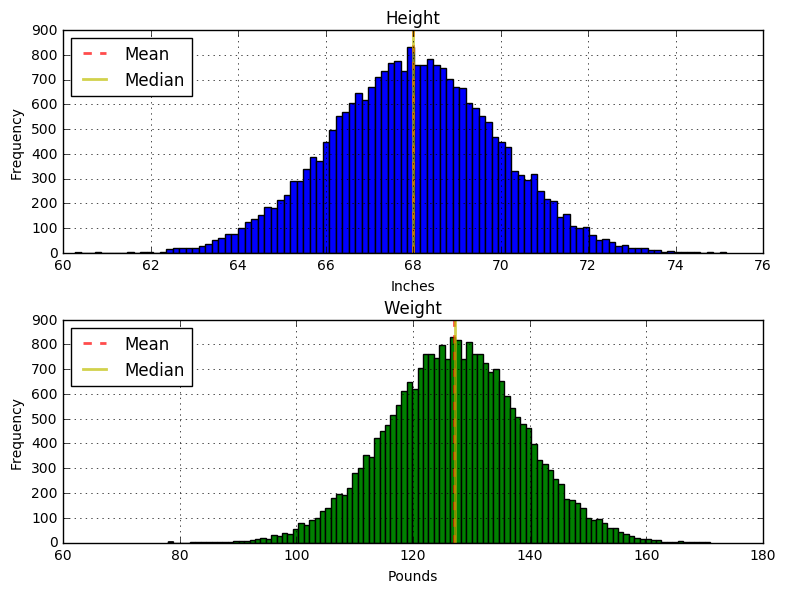

In [3]:
BINS = 100
COLORS = ['b', 'g']
Xlabels = ['Inches', 'Pounds']

# Throw error if num of colors and columns differ
assert(len(COLORS) == len(df.columns))

fig, axes = plt.subplots(len(df.columns))

# Hacky way to prevent labels overlapping
fig.tight_layout(pad=-5)
for col, axis, c, l in zip(df.columns, axes, COLORS, Xlabels):
    axis.set_ylabel("Frequency")
    axis.set_xlabel(l)
    axis.axvline(df[col].mean(), color = 'r', linestyle='dashed', linewidth=2, alpha=0.7, label="Mean")
    axis.axvline(df[col].median(), color = 'y', linewidth=2, alpha=0.7, label="Median")
    axis.legend(loc='upper left')
    df.hist(column = col, bins = BINS, ax=axis, color=c)

**[3]** Now let's add another feature: [BMI](https://en.wikipedia.org/wiki/Body_mass_index), and see how it is dependent on height and weight

In [4]:
# Since our data in inches and pounds we must apply conversion factor
BMI_column = np.multiply(np.divide(df[weight_column_index], np.power(df[height_column_index],2)), 703)

# Give a name to our new column 
BMI_column_index = "BMI"
df[BMI_column_index] = BMI_column

# Make sure we actually added column to dataframe
assert(BMI_column_index in df.columns)

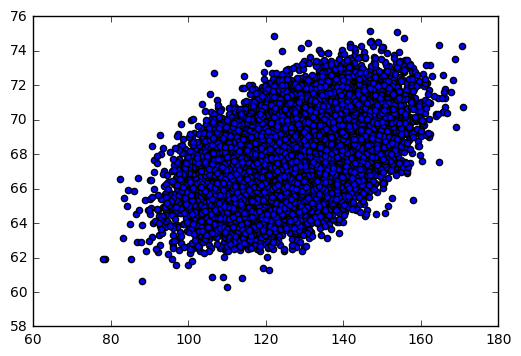

In [5]:
plt.figure()
plt.scatter(x=df[weight_column_index], y=df[height_column_index])
plt.show()

**[4]** After we calculated `BMI` let's categorize weitgh in three categories:
+ 1 - lower than 120 pounds
+ 3 - greater or equal 150 pounds
+ 2 - everything else

In [77]:
# Categorize data according with requirements
def categorize(row):
    if row[weight_column_index] < 120: return 1
    elif row[weight_column_index] >= 150: return 3
    else: return 2

category_weight_column_index = 'Weight_Category'
# Add new column to dataframe as category type    
df[category_weight_column_index] = df.apply(categorize, axis=1).astype('category')

# Make sure we actually added column to dataframe
assert(category_weight_column_index in df.columns)

And plot it boxplot of `Height` against `Weight_Category`

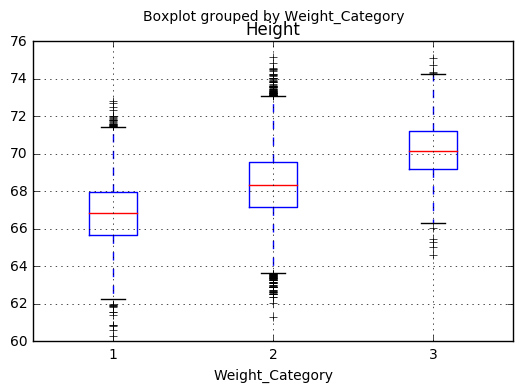

In [7]:
df.boxplot(column=height_column_index, by=category_weight_column_index)

**[5]** In addition let's plot scatterplot of height against weight.

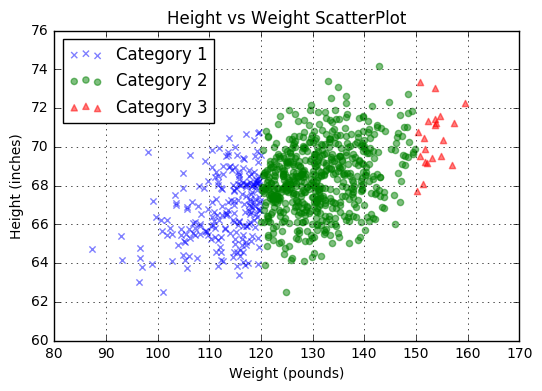

In [76]:
# Change it to sample each `sample` point
sample = 30

plt.figure()
# We will plot data by category on one plot
plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 1][::sample],
            y=df[height_column_index][df[category_weight_column_index] == 1][::sample],
            marker = 'x',
            color = 'b',
            label = 'Category 1',
            alpha = 0.5)

plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 2][::sample],
            y=df[height_column_index][df[category_weight_column_index] == 2][::sample],
            marker = 'o',
            color = 'g',
            label = 'Category 2',
            alpha = 0.5)

plt.scatter(x=df[weight_column_index][df[category_weight_column_index] == 3][::sample],
            y=df[height_column_index][df[category_weight_column_index] == 3][::sample],
            marker = '^',
            color = 'r',
            label = 'Category 3',
            alpha = 0.5)

plt.legend(loc='upper left')
plt.title('Height vs Weight ScatterPlot')
plt.ylabel('Height (inches)')
plt.xlabel('Weight (pounds)')
plt.grid()

plt.show()

Well, this is definitely not good! We have so many data points that they overlap each other resulting in big colorful blob which doesn't tell us much. Sampling less points doesn't does the trick, additionaly we mihght lose data. Perhaps heatmap will better suit our neads.

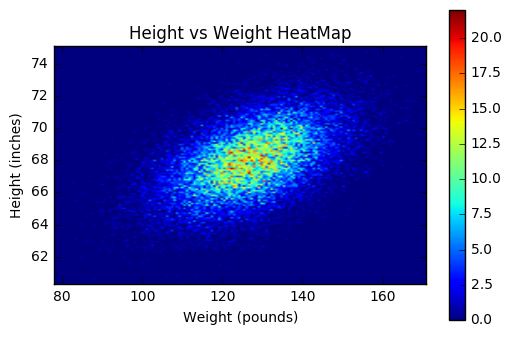

In [9]:
# Number of bins used to split data
bins = 150

heatmap, xedges, yedges = np.histogram2d(df[weight_column_index], df[height_column_index], bins=bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect=4)
plt.colorbar()
plt.title('Height vs Weight HeatMap')
plt.ylabel('Height (inches)')
plt.xlabel('Weight (pounds)')

plt.show()

**[6]** Now let's try to fit data to polynomial. We will be trying first order polynomial. But first of all we define cost function

In [10]:
# vectorized implementation of the polynomial
def polynomial(w0, w1, x):
    return np.add(w0, np.multiply(w1, x))


# loop implementation of the polynomial
def naivepolynomial(w0, w1, x):
    y = []
    for x_ in x:
        y.append(w0+w1*x_)
    return y

def error(w0, w1, y, x):
    return np.sum(np.power(np.subtract(y, polynomial(w0, w1, x)),2))

def prederror(pred, y):
    return np.sum(np.power(np.substract(y, pred)), 2)

**[7]** Then we plot two polynomials with weights `(55,0.04)` and `(50,0.22)` on scatter plot from **[5]**

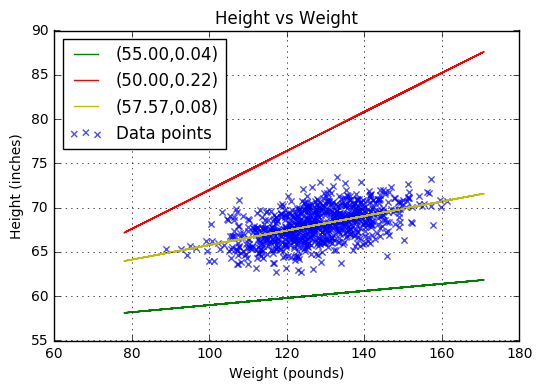

In [75]:
# Change it to sample each `skip_points`
sample = 30

plt.figure()

plt.scatter(x=df[weight_column_index][::sample],
            y=df[height_column_index][::sample],
            marker = 'x',
            color = 'b',
            alpha = 0.7,
            label = 'Data points')


x = df[weight_column_index]

# We also will plot Line of best fit to see how our weights compare to it. Do not forget to reverse order 
# of return arguments since polyfit returns highest powers first
weights = ((55,0.04), (50,0.22), np.polyfit(df[weight_column_index], df[height_column_index], 1)[::-1])
colors = ('green', 'red', 'y')

for w, c in zip(weights, colors):
    w0, w1 = w[0], w[1]
    plt.plot(x, polynomial(w0, w1, x), label="({:.2f},{:.2f})".format(w0,w1), color=c)


plt.title('Height vs Weight')
plt.ylabel('Height (inches)')
plt.xlabel('Weight (pounds)')
plt.legend(loc='upper left')
plt.grid()

plt.show()

**[8]** Let's see how error function depends on `w1` for `w0` = 50

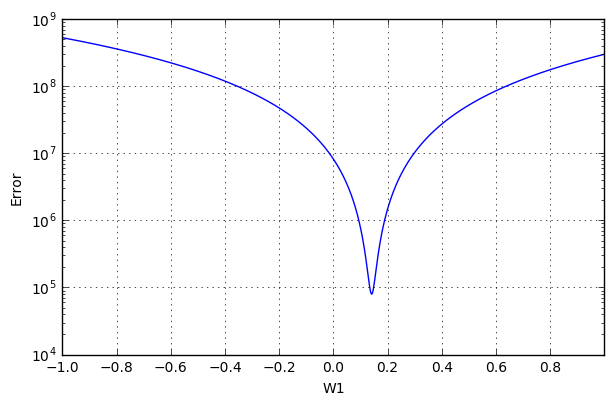

In [74]:
w0 = 50

# Changing this will change w1 range
w1_range = 1
w1 = np.linspace(-w1_range, w1_range, num=1000)

# Calculate error values
y = []
for w in w1:
    y.append(error(w0,w,df[height_column_index], df[weight_column_index]))

plt.figure()

plt.plot(w1, y)
plt.tight_layout()

# We will put ticks at 0.2*w1_range from each other 
# thus plotting cleaner graph
plt.xticks(np.arange(min(w1), max(w1), 0.2*w1_range))

# Switch to logarithm scale if max(y) is orders of magnitude larger than min(y) 
if max(y)/min(y) > 10**3: 
    plt.semilogy()

plt.xlabel("W1")
plt.ylabel("Error")

plt.grid()
plt.show()

**[10]**

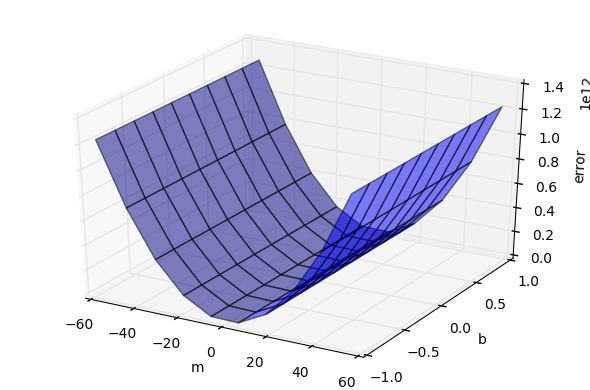

In [92]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections

def error(m, b, points):
    totalError = 0
    for i in range(0, len(points)):
        totalError += (points[i].y - (m * points[i].x + b)) ** 2
    return totalError


# Set x and y variables
x = df[weight_column_index]
y = df[height_column_index]

# Named collection but I don't think I need it
Point = collections.namedtuple('Point', ['x', 'y'])



# Create point list 
points = [Point(xp, yp) for xp,yp in zip(x, y)]

fig = plt.figure()
ax = fig.gca(projection='3d')

w0s = np.linspace(-55, 55, 10)
w1s = np.linspace(-1, 1, 10)

M, B = np.meshgrid(w0s, w1s)
zs = np.array([error(mp, bp, points) 
               for mp, bp in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)


ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.5)
plt.tight_layout()
ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('error')

plt.show()
